In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import subprocess
import random
import csv

In [45]:
import random
import csv

def is_power_of_two(n):
    return (n & (n - 1) == 0) and n != 0

def generate_cache_accesses(
    num_operations=500,
    address_start=0,
    address_end=4096,
    repeat_percentage_range=(30, 70),
    alignment=1,  # Use 4 for aligned, 1 for unaligned
    density='dense'  # 'sparse' or 'dense'
):
    if alignment == 4:
        # Aligned accesses
        addresses = list(range(address_start, address_end, alignment))
    else:
        # Unaligned accesses: each address can have an offset of 1 to 3
        addresses = list(range(address_start, address_end))
        # Generate additional addresses with random offsets of 1 to 3
        addresses_with_offsets = []
        for address in addresses:
            addresses_with_offsets.extend([address + offset for offset in range(1, 4)])
        addresses = list(set(addresses_with_offsets))  # Remove duplicates

    if density == 'dense':
        # Close together: reduce the range of addresses
        address_range = (address_end - address_start) // 4
        addresses = [address_start + (i * 4) for i in range(address_range)]
    elif density == 'sparse':
        # Spread out: use all addresses
        pass
    else:
        raise ValueError("Invalid density option. Use 'sparse' or 'dense'.")

    data_values = [
        "0x11111111",
        "0x22222222",
        "0x33333333",
        "0x44444444",
        "0x55555555",
        "0x66666666",
        "0x77777777",
        "0x88888888",
        "0x99999999",
        "0x12345678",
        "0x79824691",
        "0x16420982",
        "0x15946378",
        "0x687b890a",
        "0xf809b234",
    ]

    num_repeated_operations = int(num_operations *
                                  random.uniform(*repeat_percentage_range) / 100)
    num_unique_operations = num_operations - num_repeated_operations

    unique_accesses = []
    for _ in range(num_unique_operations):
        address = random.choice(addresses)
        if random.choice([True, False]):
            unique_accesses.append(["R", f"0x{address:08X}", ""])
        else:
            data = random.choice(data_values)
            unique_accesses.append(["W", f"0x{address:08X}", data])

    repeated_accesses = random.choices(unique_accesses,
                                       k=num_repeated_operations)

    accesses = unique_accesses + repeated_accesses
    random.shuffle(accesses)

    return accesses

def save_accesses_to_csv(num_operations=500, density='dense'):
    accesses = generate_cache_accesses(num_operations=num_operations, density=density)

    file_path = f"cache_accesses_{num_operations}.csv"

    with open(file_path, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerows(accesses)

    print(f"Generated cache accesses and saved to {file_path}")



In [21]:



def run_c_program(num,cache_line_size, l1_cache_lines, l2_cache_lines):
  command = [
      "./project", "-c", "10000000", "--cacheline-size",
      str(cache_line_size), "--l1-lines",
      str(l1_cache_lines), "--l2-lines",
      str(l2_cache_lines), "--l1-latency", "4", "--l2-latency", "16",
      "--memory-latency", "400", "--tf=tracefile", f"cache_accesses_{num}.csv"
  ]

  result = subprocess.run(command, capture_output=True, text=True)
  if result.returncode != 0:
    print(f"Error running C program: {result.stderr}")

In [4]:
column_names = ['cycles', 'misses', 'hits', 'primitiveGateCount']

def read_results_from_csv(filename):
  if os.path.exists(filename):
    return pd.read_csv(filename, names=column_names, header=None)

In [5]:
save_accesses_to_csv(500)
run_c_program(64,32,128)

Generated cache accesses and saved to cache_accesses_500.csv


In [48]:
cache_line_sizes = [8, 16, 32, 64, 128, 256]
l1_cache_lines = [8,16, 32, 64, 128]
l2_cache_lines = [64, 128, 256]
column_names = ['cycles', 'misses', 'hits', 'primitiveGateCount']
result_list = [None] * (len(l1_cache_lines))
save_accesses_to_csv(1000,density='sparse')
for i,l1_lines in enumerate(l1_cache_lines):
  results_df = pd.DataFrame()
  for cache_line_size in cache_line_sizes:
      for l2_lines in [256]:
        run_c_program(1000,cache_line_size, l1_lines, l2_lines)
        filename = 'results.csv'
        df = pd.DataFrame()
        df = read_results_from_csv(filename)
        df['cache_line_size'] = cache_line_size
        df['l1_cache_lines'] = l1_lines
        df['l2_cache_lines'] = l2_lines
        results_df = pd.concat([results_df,df], ignore_index=True)
  print(i)
  result_list[i] = results_df

print(result_list)

Generated cache accesses and saved to cache_accesses_1000.csv
0
1
2
3
4
[   cycles  misses  hits  primitiveGateCount  cache_line_size  l1_cache_lines  \
0  520905    1350   630               29177                8               8   
1  530217    1146   823               50677               16               8   
2  606585    1044   910               93937               32               8   
3  621673     928   998              180717               64               8   
4  619721     774  1094              354537              128               8   
5  615657     504  1240              702437              256               8   

   l2_cache_lines  
0             256  
1             256  
2             256  
3             256  
4             256  
5             256  ,    cycles  misses  hits  primitiveGateCount  cache_line_size  l1_cache_lines  \
0  520473    1323   640               29887                8              16   
1  529465    1099   849               51891               16     

In [7]:
import numpy as np

colors = plt.cm.viridis(np.linspace(0, 1, len(result_list)))

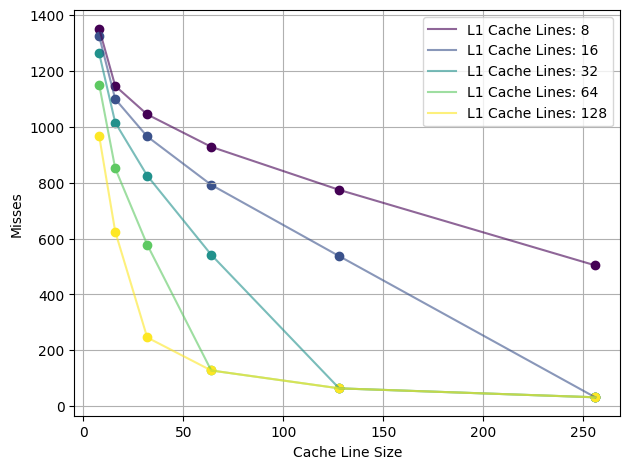

In [49]:
#plt.figure(figsize=(10, 6))
#for d in result_list:
#  for cls in cache_line_sizes:
#    subset = d[d['cache_line_size'] == cls]
#    print(subset)
#    plt.plot(subset['cache_line_size'],
#             subset['misses'],
#             label=f'Cache Line Size vs misses {cls}',
#             marker='o',
#             linestyle='-')
#  
#plt.xlabel("Cache Line Size")
#plt.ylabel("misses")
#plt.grid(True)
#plt.tight_layout()
#plt.show()

for i,d in enumerate(result_list):
  color = colors[i]
  x = d['cache_line_size']
  y = d['misses']

  plt.plot(x,y, label = f"L1 Cache Lines: {l1_cache_lines[i]}",color = color,alpha=0.6)
  plt.scatter(x, y, color=color, marker='o')

plt.xlabel("Cache Line Size")
plt.ylabel("Misses")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [56]:
cache_line_sizes = [8, 16, 32, 64, 128, 256]
l1_cache_lines = [8,16, 32, 64, 128]
l2_cache_lines = [64, 128, 256]
column_names = ['cycles', 'misses', 'hits', 'primitiveGateCount']
result_list = [None] * (len(cache_line_sizes))
save_accesses_to_csv(500,'sparse')
for i, cache_line_size in enumerate(cache_line_sizes):
  results_df = pd.DataFrame()
  for l1_lines in l1_cache_lines:
      for l2_lines in [256]:
        run_c_program(500,cache_line_size, l1_lines, l2_lines)
        filename = 'results.csv'
        df = pd.DataFrame()
        df = read_results_from_csv(filename)
        df['cache_line_size'] = cache_line_size
        df['l1_cache_lines'] = l1_lines
        df['l2_cache_lines'] = l2_lines
        results_df = pd.concat([results_df,df], ignore_index=True)
  print(i)
  result_list[i] = results_df





Generated cache accesses and saved to cache_accesses_500.csv
0
1
2
3
4
5


In [10]:
from scipy.interpolate import interp1d

/tmp/ipykernel_353361/396372764.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


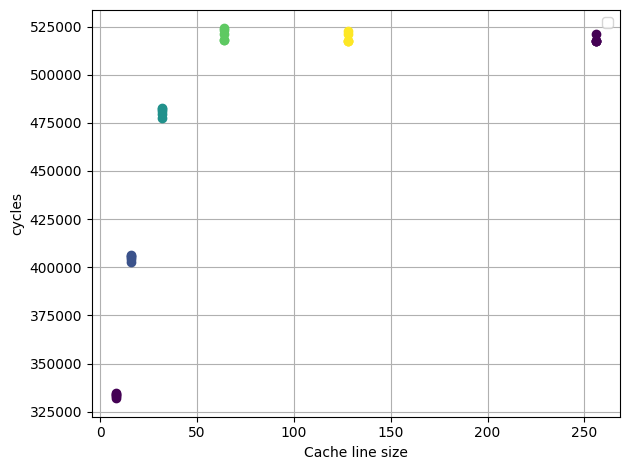

In [57]:
for i,d in enumerate(result_list):
  color = colors[i % len(colors)]
  x = d['cache_line_size']
  y = d['cycles'] 

  plt.plot(x,y,color = color,linestyle='-', marker = 'o')

plt.xlabel("Cache line size")
plt.ylabel("cycles")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()